# Dataset: Trackster neighborhood approach

Get tracksters from the cone neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - linked_inners: nodes linked to the given tracksters within its cone

Use the features from MLP approach per trackster.
Look at the graph of tracksters, extract information from the neighborhood and perform link prediction.
- convert the tracksters into some latent space and predict a link between them
- use edgeconv or sageconf to add information from the neighbourhood


In [1]:
import uproot
import numpy as np
import awkward as ak

from reco.datasetPU import TracksterGraph, get_event_graph
from reco.data import get_bary_data, get_event_data

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


ds_name = "CloseByTwoPion"
file_name = f"new_ntuples_15101852_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

In [2]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

In [3]:
eid = 0
dataset = get_event_graph(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    eid,
    radius=10,
)
print("High-energy tracksters:", len(dataset))

ds = dataset[0]

node_index = ds.node_index
pos_index = ds.y >= 0.7
neg_index = ds.y < 0.7

positive = node_index[pos_index].tolist()
negative = node_index[neg_index].tolist()

print("Trackster 0:", len(positive), "/", len(node_index))

High-energy tracksters: 6
Trackster 0: 2 / 2


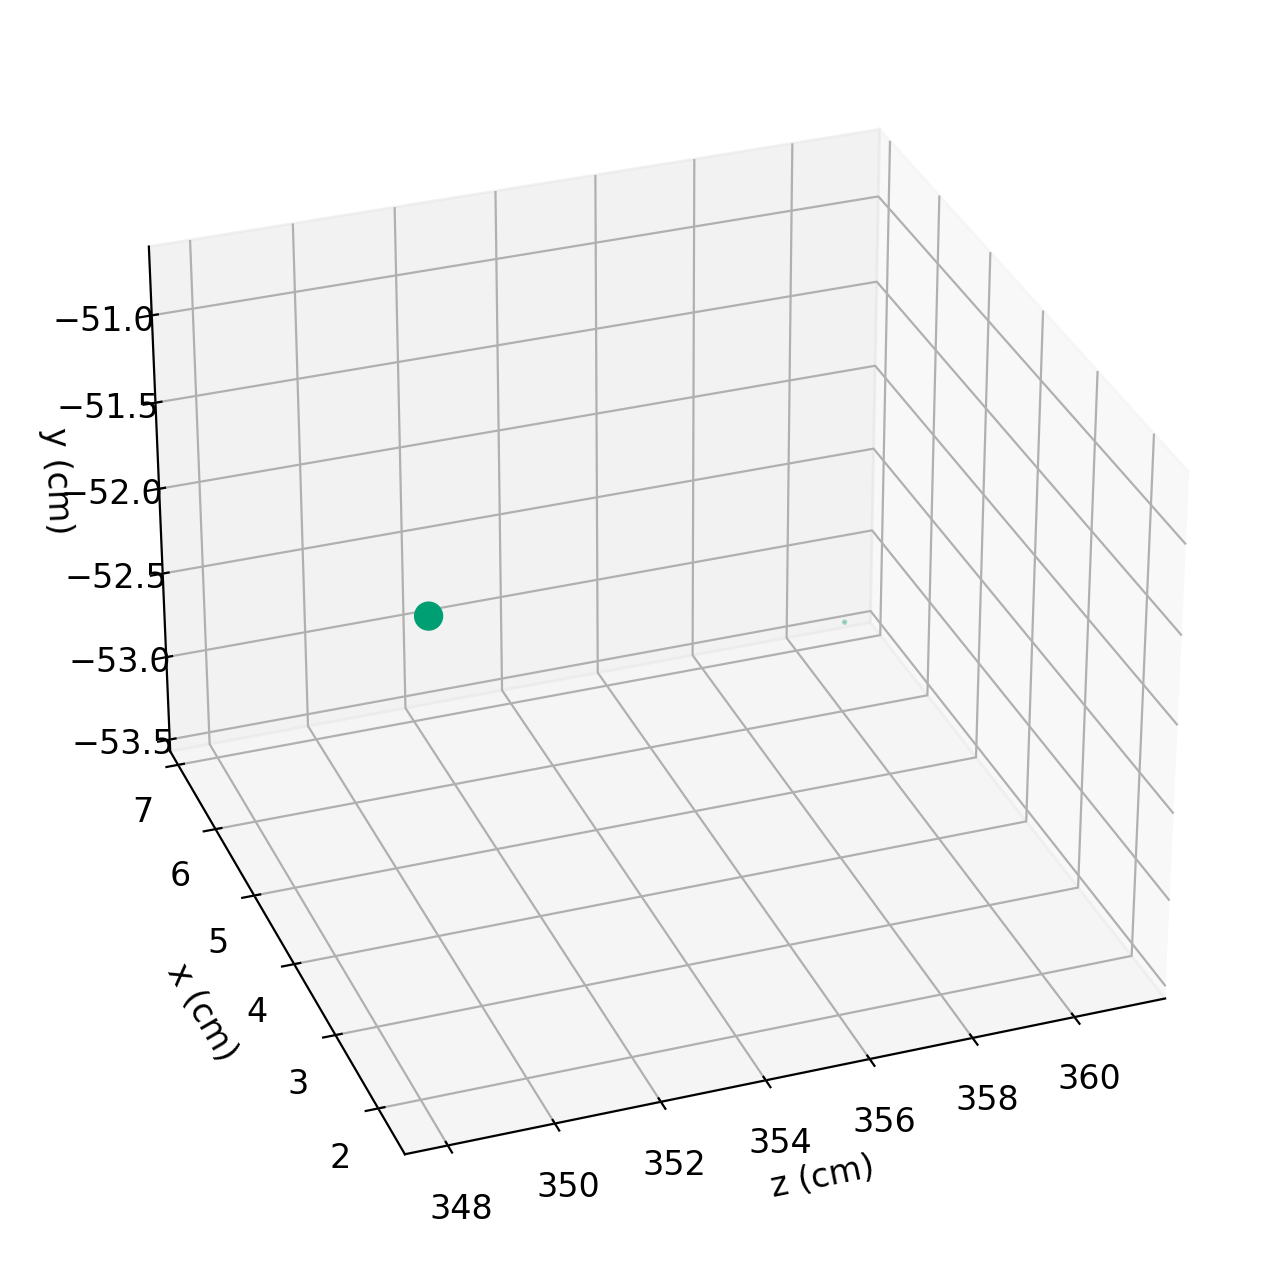

In [4]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, projection='3d')

bary = get_bary_data(trackster_data, eid)
ax1.scatter(bary[:,2][positive], bary[:,0][positive], bary[:,1][positive], s=trackster_data["raw_energy"][eid][positive], c="#009E73")
ax1.scatter(bary[:,2][negative], bary[:,0][negative], bary[:,1][negative], s=trackster_data["raw_energy"][eid][negative], c="#E69F00")

ax1.set_xlabel("z (cm)")
ax1.set_ylabel("x (cm)")
ax1.set_zlabel("y (cm)")
ax1.view_init(elev=30, azim=-110)

# plt.legend()
#fig.savefig('export/photon-PU-pairwise-edges.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Evaluation

In [11]:
from reco.evaluation import model_evaluation
from reco.dummy import DummyPleaser

In [ ]:
eth_ranges = range(0, 100, 10)
r_ranges = [10, 20, 30, 50, 100]
eth_results = []

max_events = 10

for r in r_ranges:
    _clue3D_F = []
    _target_F = []
    for eth in eth_ranges:
        print(f" --- Radius: {r} | Eth: {eth} ---")
        result = model_evaluation(
            cluster_data,
            trackster_data,
            simtrackster_data,
            assoc_data,
            DummyPleaser(),
            decision_th=0.5,
            radius=r,
            bigT_e_th=eth,
            max_events=max_events,
            reco_eval=False,
            graph=True
        )
        # ignore cases where there is nothing to do
        c3d = np.array(result["clue3d_to_sim"])[:,2]
        tgf = np.array(result["target_to_sim"])[:,2]
        # cmp_idx = c3d != tgf
        # c3d = c3d[cmp_idx] 
        # tgf = tgf[cmp_idx] 
        _clue3D_F.append(np.sum(c3d) / max_events)
        _target_F.append(np.sum(tgf) / max_events)
    eth_results.append(np.array(_target_F) - np.array(_clue3D_F))

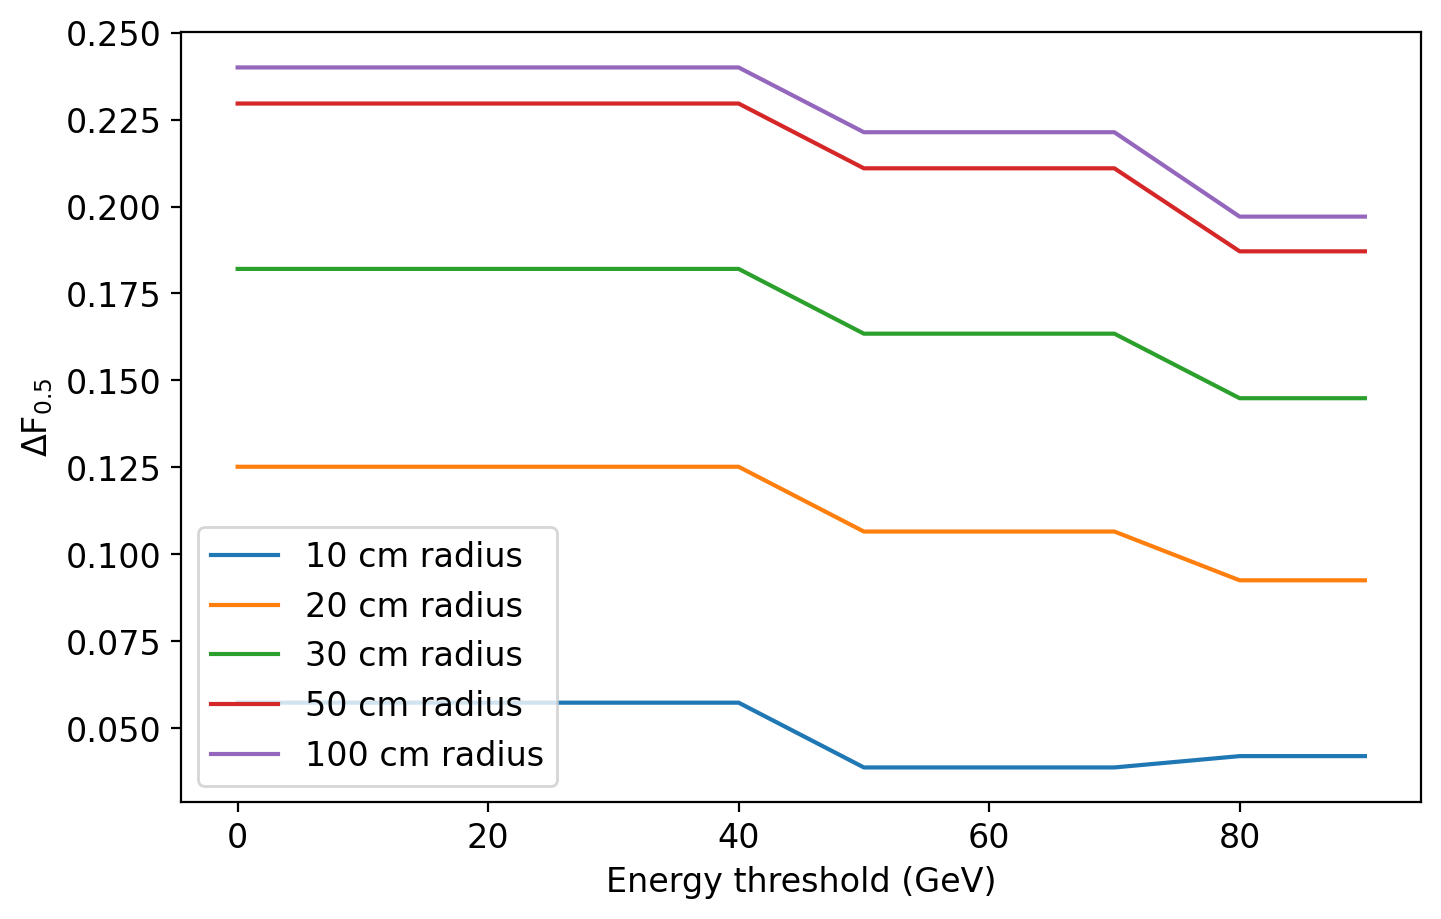

In [14]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

for r, res in zip(r_ranges, eth_results):
    ax.plot(eth_ranges, res, label=f"{r} cm radius")

ax.legend()
# ax.set_xlim(0, 100)
ax.set_xlabel("Energy threshold (GeV)")
ax.set_ylabel("$\Delta F_{0.5}$")

# outcome: 10 cm makes sense for PU, not higher

fig.savefig(f'export/{ds_name}-graph-energy-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()